# Auto Regression

Import Libraries

In [1]:
import pandas as pd
from data import OpenmeteoAPI, SQLRespository
import sqlite3
from config import settings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg


### Prepare Data

API CALL

For the purpose of this project, i will be getting my PM2.5 data using [Open Metro](https://open-meteo.com/) Api just as if have done in `air_quality1.ipynb` Notebook.

In [2]:
# open_api = OpenmeteoAPI()
# record = open_api.getPM2_5(lat=7.403546223182103, lon=3.932032049519837, start_date="2024-01-01", end_date="2024-12-18")
# record

In [3]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
repo = SQLRespository(connection=connection)

In [4]:
# repo.insert_table(table_name="PM2_5", records=record)

In [5]:
df = repo.read_table(table_name="PM2_5")

# Rename pm2_5 to PM2.5
df.rename(columns={"pm2_5" : "PM2.5"}, inplace=True)
df

,PM2.5
date,
2023-12-31 23:00:00+00:00,132.699997
2024-01-01 00:00:00+00:00,131.300003
2024-01-01 01:00:00+00:00,128.100006
2024-01-01 02:00:00+00:00,126.199997
2024-01-01 03:00:00+00:00,124.800003
...,...
2024-12-18 18:00:00+00:00,116.400002
2024-12-18 19:00:00+00:00,140.199997
2024-12-18 20:00:00+00:00,154.100006


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8472 entries, 2023-12-31 23:00:00+00:00 to 2024-12-18 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   8472 non-null   float64
dtypes: float64(1)
memory usage: 132.4+ KB


The data should be format to Series.} 

In [7]:
y = df["PM2.5"]
print(type(y))
y

<class 'pandas.core.series.Series'>


date
2023-12-31 23:00:00+00:00    132.699997
2024-01-01 00:00:00+00:00    131.300003
2024-01-01 01:00:00+00:00    128.100006
2024-01-01 02:00:00+00:00    126.199997
2024-01-01 03:00:00+00:00    124.800003
                                ...    
2024-12-18 18:00:00+00:00    116.400002
2024-12-18 19:00:00+00:00    140.199997
2024-12-18 20:00:00+00:00    154.100006
2024-12-18 21:00:00+00:00    159.699997
2024-12-18 22:00:00+00:00    155.500000
Name: PM2.5, Length: 8472, dtype: float64

In [8]:
assert isinstance(y, pd.Series), f"`y` should be Series not type {type(y)}"
assert y.isnull().sum() == 0, f"`y` should not contain any null value"

### Explore

Plot ACF plot for data `y`

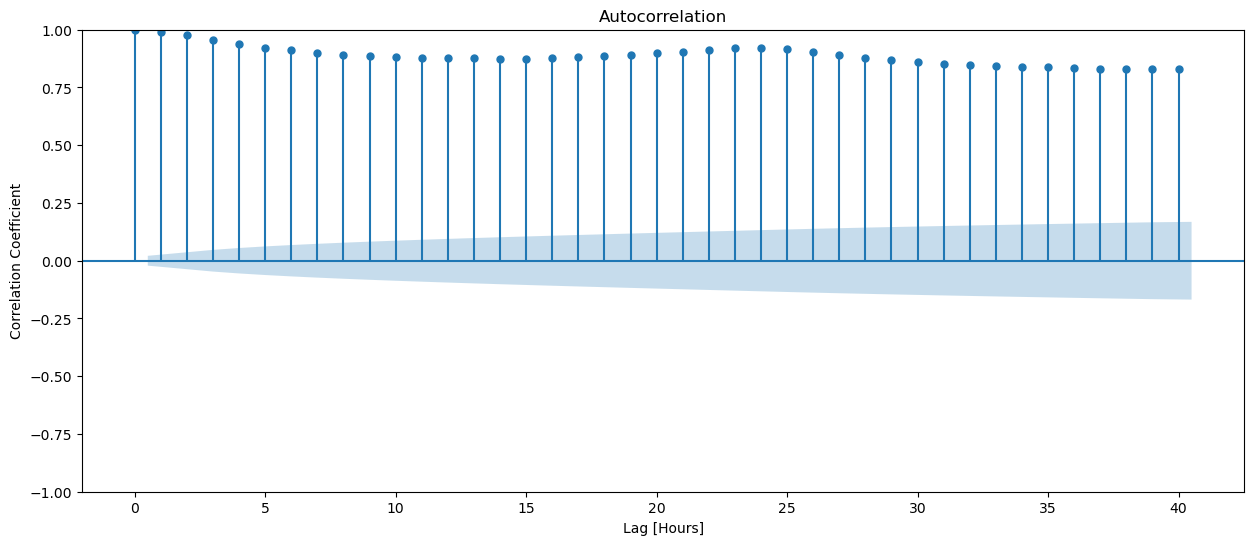

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.show();

Plot PACF plot for data `y`

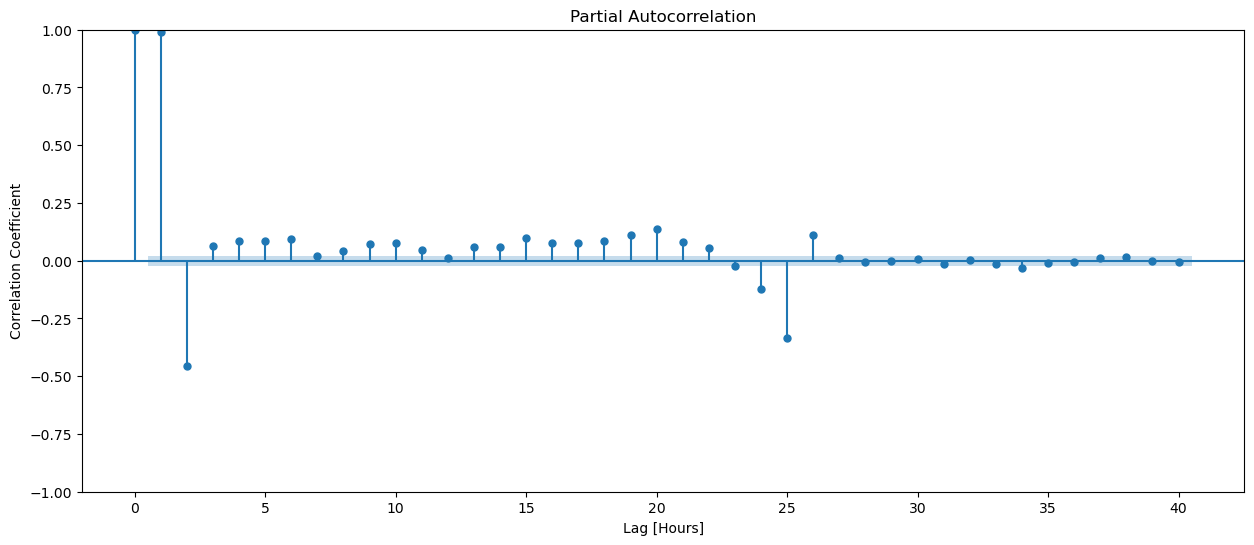

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.show();

### Split

Split `y` into training and test set. The first 95% should be training set and the remaining 5% should be in the test set. 

In [11]:
cut_off = int(len(y) * 0.95)
y_train = y.iloc[:cut_off]
y_test = y.iloc[cut_off:]

In [12]:
y_train.tail()

date
2024-12-01 02:00:00+00:00    70.500000
2024-12-01 03:00:00+00:00    60.099998
2024-12-01 04:00:00+00:00    52.700001
2024-12-01 05:00:00+00:00    51.000000
2024-12-01 06:00:00+00:00    58.599998
Name: PM2.5, dtype: float64

## Build Model

### Baseline

Calculate the mean absolute error for the model

In [13]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)


print(f"Mean P2.5 reading: {y_mean.round(2)}")
print(f"Baseline MAE: {baseline_mae.round(2)}")


Mean P2.5 reading: 34.69
Baseline MAE: 26.44


### Iterate

Instantiate **AutoReg** model and fit training data using lag of 26

In [14]:
model = AutoReg(y_train, lags=26).fit()

c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Genenerate list of training prediction and use it to calculate training mean absolute error

In [15]:
y_pred = model.predict()
y_pred.dropna(inplace=True)

In [16]:
training_mae = mean_absolute_error(y_train[26:], y_pred)
print(f"Training MAE: {training_mae}")

Training MAE: 1.9975616177807258


Getting the residuals

In [17]:
y_train_resid = model.resid
y_train_resid

date
2024-01-02 01:00:00+00:00   -5.083377
2024-01-02 02:00:00+00:00    0.323577
2024-01-02 03:00:00+00:00   -0.220096
2024-01-02 04:00:00+00:00   -2.506082
2024-01-02 05:00:00+00:00   -1.575137
                               ...   
2024-12-01 02:00:00+00:00   -4.516770
2024-12-01 03:00:00+00:00   -3.552564
2024-12-01 04:00:00+00:00   -0.704451
2024-12-01 05:00:00+00:00    2.466675
2024-12-01 06:00:00+00:00    5.306744
Length: 8022, dtype: float64

Plot of the residuals

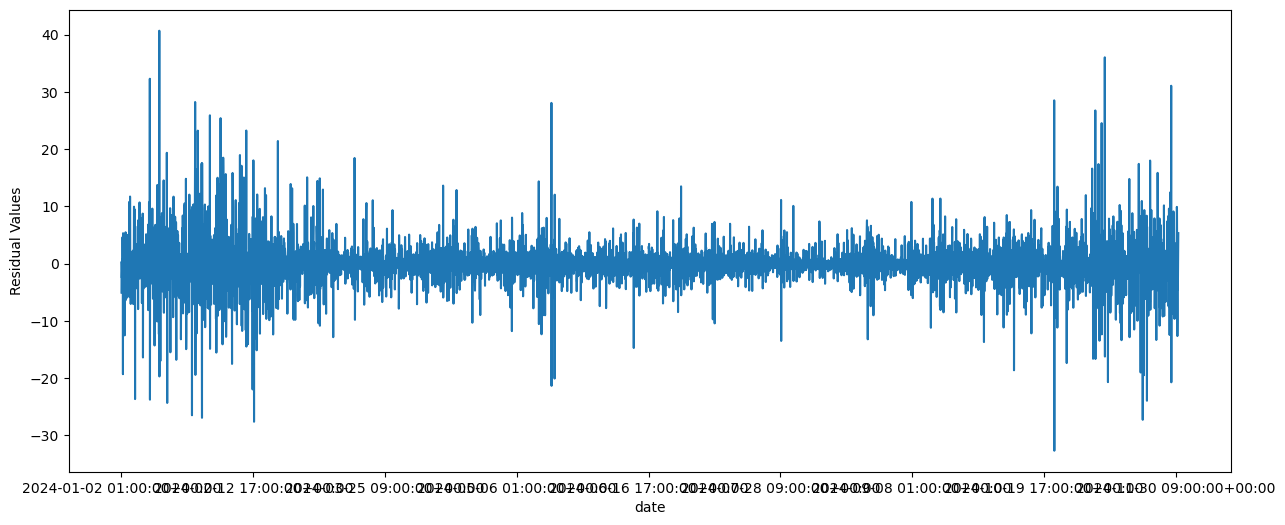

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Values", ax=ax);

Histogram of `y_train_resid`

Text(0.5, 1.0, 'AR(26), Distribution of Residuals')

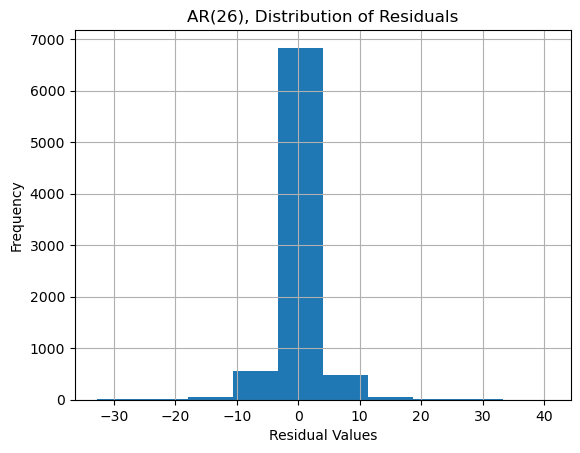

In [19]:
y_train_resid.hist()
plt.xlabel("Residual Values")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residuals")


ACF plot of `y_train_resid`

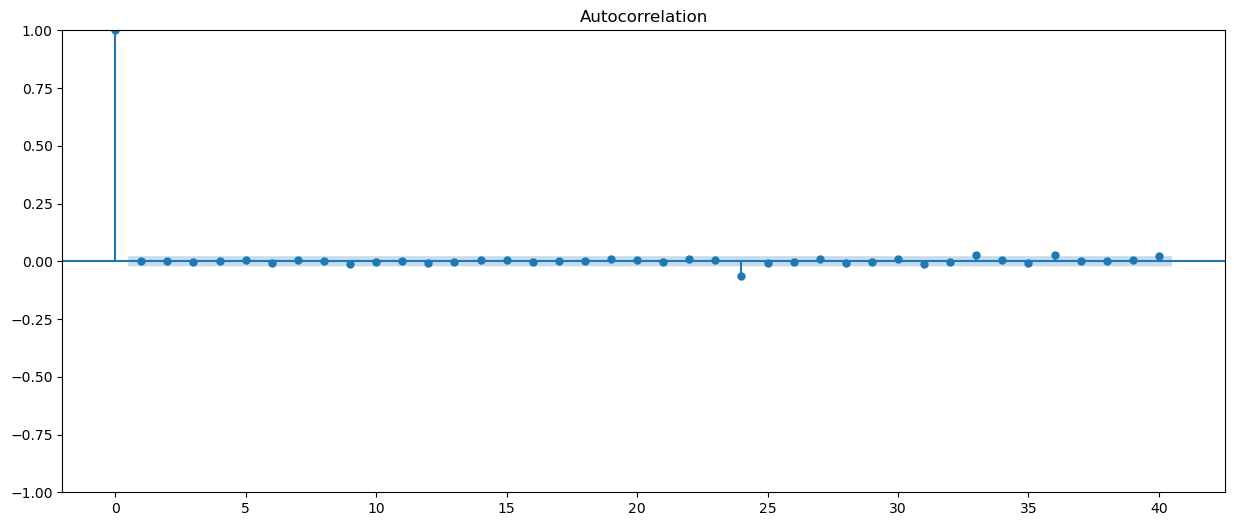

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.show();

PACF plot of `y_train_resid`

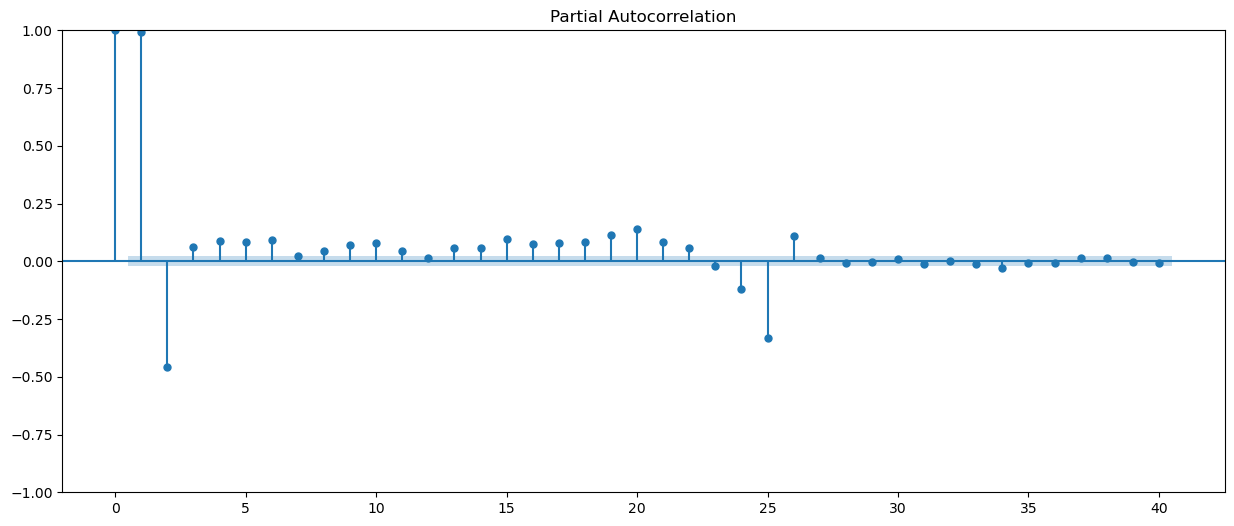

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.show();

## Evalute

In [22]:
model.predict().tail()

2024-12-01 02:00:00+00:00    75.016770
2024-12-01 03:00:00+00:00    63.652563
2024-12-01 04:00:00+00:00    53.404452
2024-12-01 05:00:00+00:00    48.533325
2024-12-01 06:00:00+00:00    53.293254
Freq: h, dtype: float64

Let's generalize and then calculate the test mean absolute error

In [23]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print(f"Test MAE: {test_mae.round(2)}")

Test MAE: 36.22


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Create DataFrame that has two columns: `y_test` and `y_pred_test`

In [24]:
df_pred_test = pd.DataFrame({
    "y_test" : y_test,
    "y_pred" : y_pred_test
}, index = y_test.index)

df_pred_test

,y_test,y_pred
date,,
2024-12-01 07:00:00+00:00,68.699997,66.640318
2024-12-01 08:00:00+00:00,77.099998,73.432368
2024-12-01 09:00:00+00:00,84.300003,77.519974
2024-12-01 10:00:00+00:00,85.199997,77.787064
2024-12-01 11:00:00+00:00,81.000000,75.562117
...,...,...
2024-12-18 18:00:00+00:00,116.400002,53.276258
2024-12-18 19:00:00+00:00,140.199997,53.236883
2024-12-18 20:00:00+00:00,154.100006,53.196366


A line plot of `y_test` and `y_pred` in **test_predictions**

In [25]:
fig = px.line(df_pred_test, labels={"value" : "PM2.5"})
fig.show()

From the above diagram, the model tried it best in predicting PM2.5 reading with lag of 26. But 

A walk-forward validation on the entire test set `y_test`.

In [39]:
%%capture
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=ValueWarning)
# Initialize an empty Series for predictions
y_pred_wfv = pd.Series(dtype=float)

# Copy the training data
history = y_train.copy()


# Walk-forward validation
for i in range(len(y_test)):
    # Fit the AutoReg model
    model = AutoReg(history, lags=26).fit()
    
    # Forecast the next value
    next_pred = model.forecast(steps=1)
    
    # Append the forecast to the predictions
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred, index=[y_test.index[i]])])
    
    # Update history with the true value from the test set
    history = pd.concat([history, y_test.iloc[i:i+1]])
    
    # Optional: Print progress
    # if i % 10 == 0 or i == len(y_test) - 1:  # Print every 10 steps and at the end
    #     print(f"Step {i + 1}/{len(y_test)}: Prediction={next_pred.values[0]}, Actual={y_test.iloc[i]}")


Calculate mean absolute error for the model

In [41]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print(f"Test MAE: {test_mae.round(2)}")

Test MAE: 5.5


The parmeters of the trained model

In [42]:
print(model.params)

const        0.105726
PM2.5.L1     1.411728
PM2.5.L2    -0.491112
PM2.5.L3    -0.001351
PM2.5.L4     0.014290
PM2.5.L5    -0.042112
PM2.5.L6     0.070844
PM2.5.L7    -0.015588
PM2.5.L8    -0.016550
PM2.5.L9     0.004694
PM2.5.L10   -0.021339
PM2.5.L11    0.062553
PM2.5.L12   -0.041005
PM2.5.L13    0.016702
PM2.5.L14   -0.015727
PM2.5.L15    0.004508
PM2.5.L16    0.009027
PM2.5.L17    0.005738
PM2.5.L18   -0.005224
PM2.5.L19   -0.018360
PM2.5.L20    0.036637
PM2.5.L21   -0.003101
PM2.5.L22    0.003601
PM2.5.L23    0.041767
PM2.5.L24    0.393564
PM2.5.L25   -0.588733
PM2.5.L26    0.181888
dtype: float64


Create DataFrame that has two columns: `y_test` and `y_pred_wfv`

In [43]:
df_pred_test = pd.DataFrame({
    "y_test" : y_test,
    "y_pred_wfv" : y_pred_wfv
}, index = y_test.index)

df_pred_test

,y_test,y_pred_wfv
date,,
2024-12-01 07:00:00+00:00,68.699997,66.640318
2024-12-01 08:00:00+00:00,77.099998,76.325860
2024-12-01 09:00:00+00:00,84.300003,81.688467
2024-12-01 10:00:00+00:00,85.199997,85.553995
2024-12-01 11:00:00+00:00,81.000000,82.765885
...,...,...
2024-12-18 18:00:00+00:00,116.400002,109.761623
2024-12-18 19:00:00+00:00,140.199997,125.934654
2024-12-18 20:00:00+00:00,154.100006,148.245589


A line plot of `y_test` and `y_pred_wfv` in **test_predictions**

In [44]:
fig = px.line(df_pred_test, labels={"value" : "PM2.5"})
fig.show()